In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import matplotlib as mpl

In [20]:
# Création d'un graph à N chambres

def graph_1D_N_chambers(N):
    """
    Graph 1D de N chambres magmatiques, compressibilités et conductivités constantes
    Chambre 0 : compressibilité infinie
    """
    
    G = nx.Graph()
    
    # 1. ajout des noeuds
    G.add_node(0, compressibility=1e12)
    for i in range(1,N+1):
        G.add_node(i, compressibility=1)
        
    # 2. ajout des arrêtes
    for i in range(N):
        G.add_edge(i, i+1, conductivity=1)
        
    return G

In [23]:
def draw_chambers(G, node_size_factor=400, edge_width_factor=4):   
    
    seed = 13648
    pos = nx.spring_layout(G, seed=seed)
    
    node_sizes = [G.nodes[node]["compressibility"]*node_size_factor for node in G.nodes]
    node_sizes[0] = 5*node_size_factor
    edge_sizes = [G.edges[edge]["conductivity"]*edge_width_factor for edge in G.edges]

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="indigo")
    nx.draw_networkx_edges(
        G,
        pos,
        node_size=node_sizes,
        width=edge_sizes,
    )
    
    nx.draw_networkx_labels(G, pos, font_color="w")

    ax = plt.gca()
    ax.set_axis_off()
    plt.show()

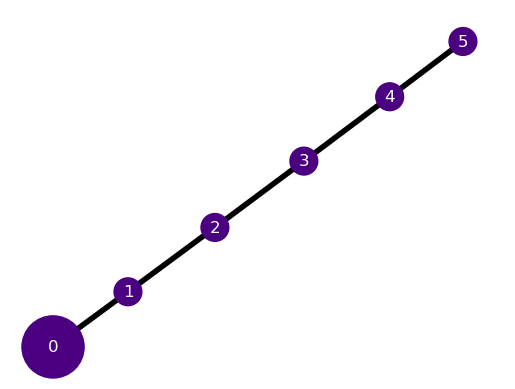

In [24]:
G = graph_1D_N_chambers(5)

draw_chambers(G)

In [25]:
# Construction de la matrice du système A

def get_compressibility(G,i):
    """Retourne la compressibilité de la chambre i"""
    return G.nodes[i]["compressibility"]

def get_conductivity(G,i,j):
    """Retourne la conductivité du conduit entre i et j"""
    try :
        # print(i,j,G.get_edge_data(i,j)["conductivity"])
        return G.get_edge_data(i,j)["conductivity"]
    except:
        # print(i,j,0)
        return 0.


def build_matrix_A(G):
    """ 
    Construit à partir de la description du système sous forme de graph la matrice A du système dp/dt = Ap
    """
    
    # Initiation matrice
    N = len(G) - 1 # N'inclut pas la source 
    A = np.zeros((N,N))
    
    # Remplissage des coefficients 
    for i in range(1,N+1):
        for j in range(1,N+1):
            
            # Terme en i,i
            if j == i: 
                # print("i=j",i)
                A[i-1,i-1] = - sum([get_conductivity(G,i,k) for k in range(N+1) if k != i]) / get_compressibility(G,i)
                
            # Terme en i,j (j!=i)
            else : 
                # print("i!=j",i,j)
                A[i-1,j-1] = get_conductivity(G,i,j)/get_compressibility(G,i)
        
    return A 

def build_vector_B(G):
    
    # Initiation matrice
    N = len(G) - 1 # N'inclut pas la source 
    B = np.zeros(N)
    
    for i in range(1,N+1):
        B[i-1] = get_conductivity(G,0,i)/get_compressibility(G,i)
        
    return B
        

In [26]:
def compute_pressure_time_serie(G, source, t_max, p0):
    
    # Domaine temporel de résolution (système adimentionalisé : temps caractéristique ~ 1)
    t_space = np.linspace(0.,t_max,1000)
    
    # Construction matrice du système 
    A = build_matrix_A(G)
    B = build_vector_B(G)
    
    source_B = lambda t : B * source(t)

    # Résolution du système
    def system(p, t):
        dpdt = np.dot(A, p) + source_B(t)
        return dpdt 

    p = odeint(system, p0, t_space)
    
    return p

In [27]:
# Construction du graph des chambres
N = 3
G = graph_1D_N_chambers(N) 

# Conditions initiales
p0 = np.zeros(N)

# définition du terme source : ici marche de pression dans la chambre 0
def source(t, t_s=1.): return 1 if t >= t_s else 0

# temps résolution
t_max = 20.

p = compute_pressure_time_serie(G, source, t_max, p0)

[]

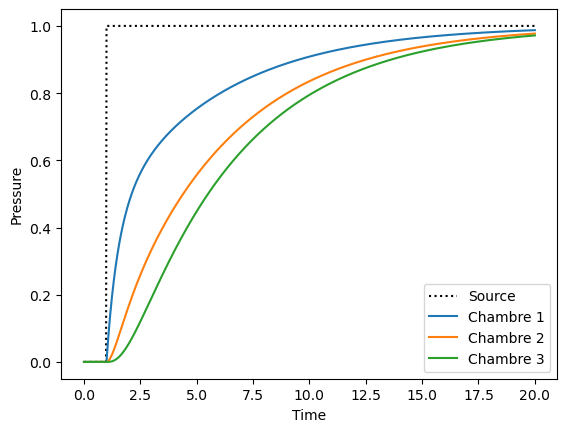

In [28]:
# Tracé des pressions dans les 3 chambres au cours du temps 
t_space = np.linspace(0, t_max, p.shape[0])
plt.plot(t_space, [source(t_) for t_ in t_space], label="Source", color="k", ls=":")

for i in range(N):
    plt.plot(t_space, p[:,i], label=f"Chambre {i+1}")
    
plt.xlabel("Time")
plt.ylabel("Pressure")
plt.legend()
plt.plot()

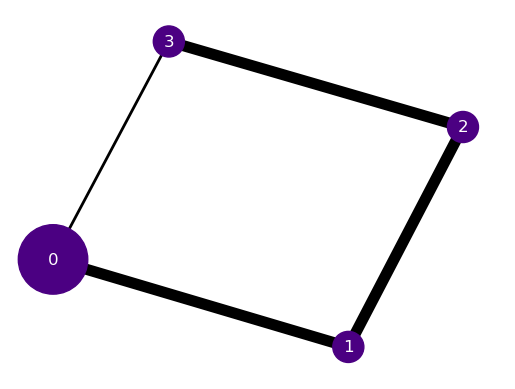

In [29]:
# Exemple plus complexe
G = nx.Graph()

# 1. ajout des noeuds
G.add_node(0, compressibility=1e12)
for i in range(1,4):
    G.add_node(i, compressibility=1)
    
# 2. ajout des arrêtes
G.add_edge(0, 1, conductivity=4)
G.add_edge(1, 2, conductivity=4)
G.add_edge(2, 3, conductivity=4)
G.add_edge(0, 3, conductivity=1)

draw_chambers(G, node_size_factor=500, edge_width_factor=2)

In [35]:
# Construction du graph des chambres
N = len(G) - 1

# Conditions initiales
p0 = np.zeros(N)

# définition du terme source : ici marche de pression dans la chambre 0
def source(t, t_s=1.): return 1 if t >= t_s else 0

# temps résolution
t_max = 5.

p = compute_pressure_time_serie(G, source, t_max, p0)

[]

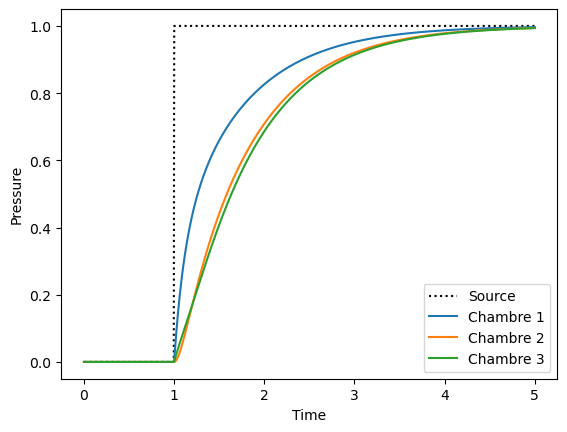

In [36]:
# # Tracé des pressions dans les 3 chambres au cours du temps 
# plt.plot(t, [source(t_)[0] for t_ in t], label="Source", color="k", ls=":")

t_space = np.linspace(0, t_max, p.shape[0])
plt.plot(t_space, [source(t_) for t_ in t_space], label="Source", color="k", ls=":")

for i in range(N):
    plt.plot(t_space, p[:,i], label=f"Chambre {i+1}")
    
plt.xlabel("Time")
plt.ylabel("Pressure")

# plt.xlim([0, 10])

plt.legend()
plt.plot()